# Interesting Papers

https://www.sciencedirect.com/science/article/pii/S0960077920303246?casa_token=g3PE29gmlPYAAAAA:Me4yIHdPkev1fSpsUuW0CkhVwXr4aH3cUHNkj__WwSZt6XGA1Nmk6wUEDMshkHyOCiLcwYY#sec0002

https://www.jstor.org/stable/4576118?seq=4

https://nzmj.org.nz/media/pages/journal/vol-131-no-1487/new-zealand-s-experience-of-the-1918-19-influenza-pandemic-a-systematic-review-after-100-years/ef4958102b-1696475878/new-zealand-s-experience-of-the-1918-19-influenza-pandemic-a-systematic-review-after-100-years.pdf

https://www.sciencedirect.com/science/article/pii/S1755436511000053

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import pandas as pd
from scipy.optimize import curve_fit
from datetime import datetime
import numpy.typing as npt
from scipy.optimize import minimize
import numpy.typing as npt

In [2]:
from SEIRD_model_files import SEIRD_model 
from SEIRD_model_files import SEIRD_fitting
#import importlib
#importlib.reload(SEIRD_model)
#importlib.reload(SEIRD_fitting)

# Generalized multi-population SEIRD Model 

The number of susceptible $S$, infectious $I$, recovered $R$, and deceased (or non-interacting) $D$ for a given population group $g$ is stored in the Y matrix: $Y^{g}_{c}$, where $g$ is the population (stored in rows), and $c$ is the category ($S^g$, $E^g$, $I^g$, $R^g$ or $D^g$). Thus, in this case $Y$ is an $N$ by 5 matrix, where $N$ is the number of different populations. 

The $\theta$ matrix contains information about how the populations mix. It is an $N$ by $N$ matrix $\theta^i_g$, each element of which has the proportion of population group $g$ that spend that timestep in mixing environment $i$. It can also be thought of as the probability that a person from population $g$ will spend time in mixing environment $m$. $\sum_{m} \theta^m_g = 1$. 

$$ \sum_{g} \theta^m_g ~ Y^{g}_{c} = B^{m}_{c}, $$

where $B^m_c$ is an $M$ by 5 matrix of the number of people in mixing environment $m$ (e.g. young-people env, old folk env) that are of type $c$ (susceptible, exposed, infectious, recovered, or dead). 

The number of new infections in a particular group $g$ depends on their exposure to infectious people while visiting another population's environment, plus the exposure encountered by those who stayed. 

\begin{align}
\text{New Infections for those of type $g$ going to mixing environment }m &= \text{\# susceptible who go} \times \beta_m \times \frac{\text{\# infectious in }m}{\text{total \# in }m}, \\
&= S^g\theta^m_g \times \beta_m \times \frac{B^m_{\text{infectious}}}{B^m_{\text{susceptible}} + B^m_{\text{exposed}} + B^m_{\text{infectious}} + B^m_{\text{recovered}}}.
\end{align}

Thus, the total number of infections can be calculated:
\begin{align}
\text{New Infections for those in group }g &= \sum_{\text{places visited } m}\text{\# susceptible from $g$ who went to }m \times \beta_m \times \frac{\text{\# infectious in }m}{\text{total \# in }m}, \\
\frac{\text{d}E_g}{\text{d}t} &= Y^g_S \sum_{m} \theta^m_g  \beta_m \times \frac{B^m_{\text{infectious}}}{B^m_{\text{susceptible}} + B^m_{\text{exposed}} + B^m_{\text{infectious}} + B^m_{\text{recovered}}},\\
&=  Y^g_S\sum_{m}\theta^m_g\beta_m \frac{\sum_{g'}\theta^m_{g'} ~ Y^{g'}_{I}}{\sum_{g''}\sum_{c=S,E,I,R} \theta^m_{g''} ~ Y^{g''}_{c}}, \\
\end{align}

A deliberate choice is made here to removed the dead from the population. The logic here is that when folk visit somewhere, they are not mixing with the dead. Thus, dead folk do not reduce the propensity for infection --- they simply are removed from the overall population. However, the number of dead is so small this is probably a small perturbation. 



# Training the model on NZ data

We're going to do it with some ages, and the aim to get the $t \rightarrow \infty$ limit for the number of deaths equal to the total number of deaths of the age ranges and sexes.

But, for starters, we'll just train the simple SEIRD model on NZ data. 



In [5]:
NZ_death_data = pd.read_csv('SEIRD_model_files/mil_and_civ_deaths_by_date.csv')
#NZ_death_data.loc[:,'Total'] = NZ_death_data.loc[:,'0-19']+NZ_death_data.loc[:,'20-49']+NZ_death_data.loc[:,'50+']
NZ_death_data

,date_death,N,Y
0,1918-10-08,0.0,2.0
1,1918-10-09,0.0,1.0
2,1918-10-10,0.0,1.0
3,1918-10-11,1.0,4.0
4,1918-10-12,0.0,6.0
...,...,...,...
132,1919-02-22,0.0,2.0
133,1919-02-23,0.0,1.0
134,1919-02-24,0.0,2.0
135,1919-02-25,0.0,3.0


# From NZ yearbook 1919

A total of 9,924 troops were in training at the date of the Armistice. __The complete number of troops and nurses provided for foreign service up to the cessation of hostilities was therefore 110,368__—more than 10 per cent. of the Dominion's total mean population in 1914. A further total of 3,370 are known to have left New Zealand to serve in British and Australian Forces.

The great majority of these troops were volunteers. Of __124,211 men provided from the commencement of the war to the 12th November, 1918__, 91,941 were volunteers, and 32,270 were conscripted under the Military Service Act, 1916.

__"Wastage" whilst undergoing training accounted for a loss to the Force of 11,333__.
CASUALTIES .

Casualties in the Expeditionary Force were, unfortunately, very high. The following is a summary as on the 4th August, 1919:—
—	officers.	Other Ranks.	Totals.
Killed in action	489	9,751	10,240
Died of wounds	200	3,763	3,963
Died of disease	64	1,535	1,599
Died, cause unknown	12	806	818
Drowned	10	58	68
__Total dead__	775	15,913	__16,688__
Missing	Nil	1	1
Prisoners of war	Nil	Nil	Nil.
__Wounded__	1,721	39,594	__41,315__
Grand total	2,496	55,508	58,004

__On the declaration of the Armistice in November, 1918, the following New Zealand troops were overseas:__—
In France	24,115
In England	23,467
In Egypt	4,541
__Total	52,123__

In deciding the order of return to New Zealand it was arranged that as a general principle those who had been longest on service were to be returned first, but that all invalids and convalescents were to be got away as rapidly as suitable transport was available and their condition permitted.

__An average of 4,500 men per month from the United Kingdom and France, and 500 men per month from Egypt, were returned to New Zealand from the date of the Armistice.__

Approximately 3,000 wives and 600 children of New Zealand soldiers who were married abroad were brought to New Zealand in the troopships during the period of demobilization.

Men demobilized in New Zealand after active service abroad have been given four weeks' leave on full pay, together with a privilege railway pass entitling them to travel free on the New Zealand railways for that period.

Total civilian deaths = 7969.0,    Total military deaths = 1069.0


(Text(0.5, 0, 'Date'),
 Text(0, 0.5, 'Deaths per day'),
 <matplotlib.legend.Legend at 0x7f11a26d4440>)

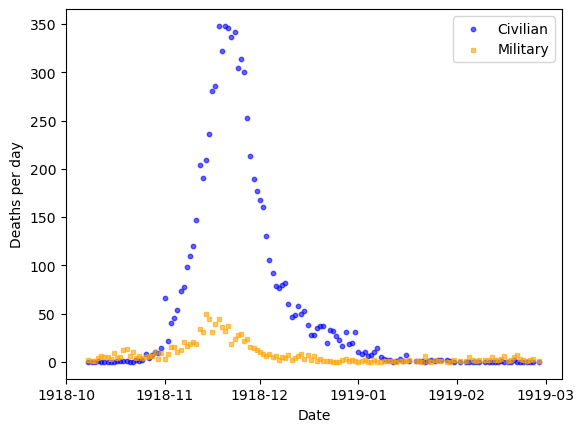

In [6]:
y_civ = NZ_death_data.sort_values('date_death')['N']
y_mil = NZ_death_data.sort_values('date_death')['Y']

print("Total civilian deaths = {},    Total military deaths = {}".format(y_civ.sum(), y_mil.sum()))

y_data = np.array([y_civ, y_mil])

sigma_data = np.maximum(np.ones(y_data.shape),np.sqrt(y_data))

xplot = pd.to_datetime(NZ_death_data.sort_values('date_death').loc[:,'date_death'])
dummy = xplot
dummymin = min(xplot)
x_data = dummy.apply(lambda l: l - dummymin).dt.days

plt.scatter(xplot, y_civ, color='blue', marker='o', label='Civilian', alpha=.6, s=10)
plt.scatter(xplot, y_mil, color='orange', marker='s', label='Military', alpha=.6, s=10)
#plt.scatter(xplot, y_old, color='red', marker='^', label='50+', alpha=.6, s=10)
plt.xlabel('Date'), plt.ylabel('Deaths per day'), plt.legend()

# Fitting the data

In [7]:
class ModelHandler:
    """Class to communicate between fitting methods defined in SEIRD_fitting, and models defined in SEIRD_model.

    Should be changed each time dimensions of Y_0 are changed or the number of mixing environments is changed. 
    """
    def __init__(self,
                 seird_model,
                 date_of_first_infection,
                 dates,
                 Y_0):
        self.seird_model = seird_model
        self.date_of_first_infection = date_of_first_infection
        self.dates = dates
        self.fitting_params = self.get_fitting_params_from_model()
        self.Y_0 = Y_0

    def get_derivs_per_day(self):
        """Should rarely be a need to change"""
        return self.seird_model.compute_derivs_per_day(self.dates,
                                                       self.date_of_first_infection,
                                                       self.Y_0)
        
    def get_fitting_params_from_model(self):
        """Sets how fitting parameters are related to the model attributes.

        Should be altered each time a new number of parameters is set, e.g. changing the number of groups or mixing environments. 
        """
        return [self.date_of_first_infection,
                self.seird_model.beta_vector[0],
                self.seird_model.beta_vector[1],
                self.seird_model.gamma,
                self.seird_model.delta[0],
                self.seird_model.theta_matrix[0,0],
                self.seird_model.theta_matrix[0,1]]
    
    def set_fitting_params_for_model(self, params):
        """Setting how the models parameters change.
        
        Should be altered each time a new number of parameters is changed, or the number of mixing environments, etc.
        """
        self.date_of_first_infection  = params[0]
        self.seird_model.beta_vector  = [params[1], params[2]]
        self.seird_model.gamma        = params[3]
        self.seird_model.delta        = params[4]*np.array([1.,1.])
        self.seird_model.theta_matrix = ModelHandler.build_theta_matrix(params[5], params[6])

    def print_params(self):
        print("Fitting parameters:\n")
        print("Date of first infection = {}".format(self.date_of_first_infection))
        print("beta_vector             = {}".format(self.seird_model.beta_vector))
        print("gamma                   = {}".format(self.seird_model.gamma))
        print("delta                   = {}".format(self.seird_model.delta))
        print("theta_matrix            =\n{}".format(self.seird_model.theta_matrix))
    
    @staticmethod
    def build_theta_matrix(*args) -> npt.NDArray:
        """Builds the theta matrix from a series of arguments. 
    
        Args:
          If first argument is 'Default', the args should be
          the parameters that go into the theta matrix.
          Otherwise args[0], then it should be a function to call and pass the rest of the arguments to. Can be an externally defined function, held as self.theta_matrix_building_method. 
    
        Returns:
          theta_matrix (npt.NDArray): 
            The matrix $\theta^i_g$ that couples population groups $g$ to mixing environments $i$. 
            Should be shape $M\times N$, where $M$ is the number of mixing environments and $N$ the number of pop groups. 
        """
        theta_matrix = np.array([[   args[0],    args[1]],
                                 [1.-args[0], 1.-args[1]]])
        return theta_matrix

In [8]:
Y_day_0_of_infection = np.array([[1000000, 0, 0, 0, 0],
                                 [46557-1, 0, 1, 0, 0]])

gamma_0, delta_0 = 0.18, 0.002*np.array([1.,1.])

beta_vector_0 = [0.3, 0.9]

latent_period = 1.4

theta_c1_0, theta_m1_0 = 0.7, 0.3
theta_matrix_0 = ModelHandler.build_theta_matrix( theta_c1_0, theta_m1_0)

day_of_first_infection_0 =-15

bounds=[(-50,60), (0.1,2.), (0.1,2.0), (0.01,1.), (0.000, 0.1), (0.,1.), (0.,1.)]

In [9]:
my_model = SEIRD_model.SEIRD_model(beta_vector_0, gamma_0, delta_0, latent_period, theta_matrix_0)

my_model_handler = ModelHandler(my_model, # SEIRD_model object
                                day_of_first_infection_0, # day of first infection
                                x_data, # list of dates being used
                                Y_day_0_of_infection) # Y_0 

my_fit = SEIRD_fitting.fitting_deaths(x_data,
                                      y_data,
                                      sigma_y=sigma_data,
                                      seird_model=my_model,
                                      bounds=bounds,
                                      model_handler = my_model_handler)
my_fit.model_handler.print_params()

Fitting parameters:

Date of first infection = -15
beta_vector             = [0.3, 0.9]
gamma                   = 0.18
delta                   = [0.002 0.002]
theta_matrix            =
[[0.7 0.3]
 [0.3 0.7]]


Xi value = 78.34285523116657


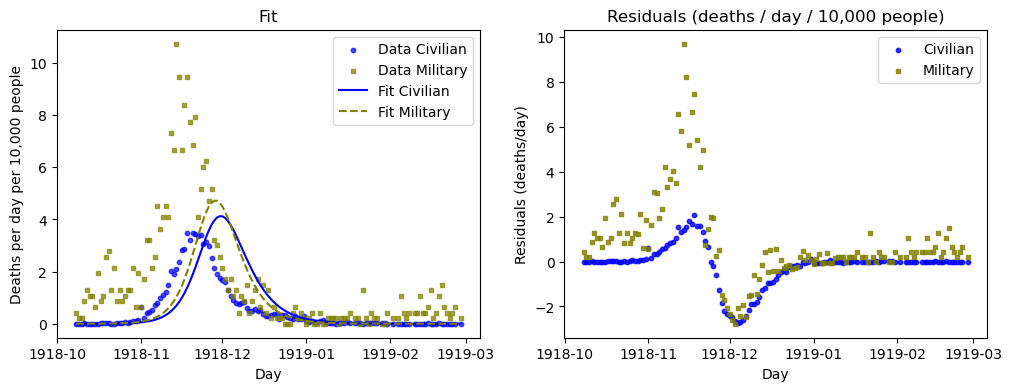

In [10]:
my_fit.plot_fit(labellist=['Civilian', 'Military'], xplot=xplot, plot_rate=True)

In [11]:
%%time
my_fit.do_minimize()
my_fit.opt

CPU times: user 1min 43s, sys: 23.6 ms, total: 1min 43s
Wall time: 1min 43s


       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 19.443281854347973
             x: [-1.447e+01  4.718e-01  7.043e-01  1.132e-01  9.192e-04
                  9.825e-01  1.984e-01]
           nit: 2057
          nfev: 3237
 final_simplex: (array([[-1.447e+01,  4.718e-01, ...,  9.825e-01,
                         1.984e-01],
                       [-1.447e+01,  4.718e-01, ...,  9.825e-01,
                         1.984e-01],
                       ...,
                       [-1.447e+01,  4.718e-01, ...,  9.825e-01,
                         1.984e-01],
                       [-1.447e+01,  4.718e-01, ...,  9.825e-01,
                         1.984e-01]], shape=(8, 7)), array([ 1.944e+01,  1.944e+01,  1.944e+01,  1.944e+01,
                        1.944e+01,  1.944e+01,  1.944e+01,  1.944e+01]))

In [12]:
my_fit.model_handler.print_params()

Fitting parameters:

Date of first infection = -14.465775029646583
beta_vector             = [np.float64(0.4718352758721264), np.float64(0.7042933998105343)]
gamma                   = 0.11323188364661926
delta                   = [0.00091925 0.00091925]
theta_matrix            =
[[0.98246681 0.19844591]
 [0.01753319 0.80155409]]


Xi value = 19.443281854347973


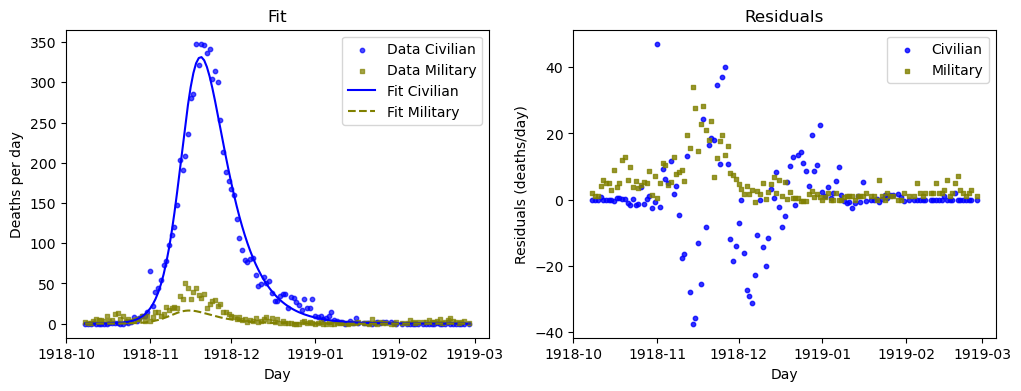

In [13]:
my_fit.plot_fit(labellist=['Civilian','Military'], xplot=xplot)
#plt.savefig('Fit_civ_mil.pdf')

Xi value = 16.12811942091598


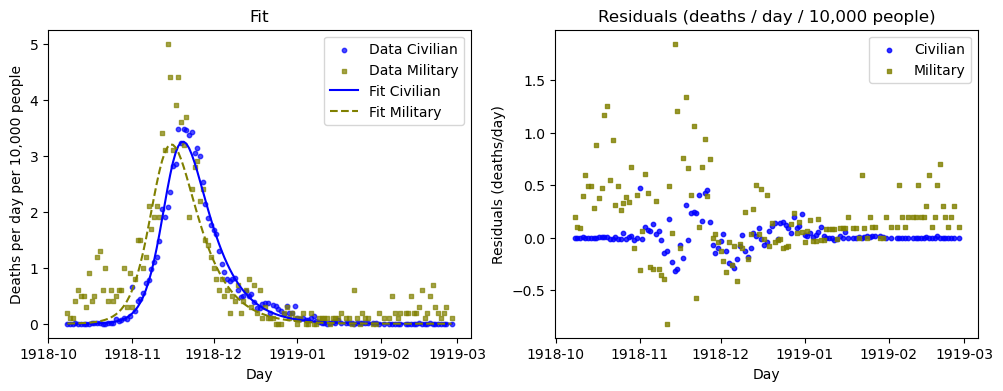

In [95]:
my_fit.plot_fit(labellist=['Civilian','Military'], xplot=xplot, plot_rate=True)
#plt.savefig('Fit_civ_mil.pdf')

In [61]:
my_fit.model_handler.print_params()

Fitting parameters:

Date of first infection = 0.0005981694765006584
beta_vector             = [np.float64(0.37413726611231896), np.float64(0.46711971300530214)]
gamma                   = 0.15474971925461567
delta                   = [0.00122538 0.00122538]
theta_matrix            =
[[0.65502559 0.11275381]
 [0.34497441 0.88724619]]
